In [26]:
import pandas as pd
import numpy as np
import torch

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from sklearn.linear_model import SGDClassifier
from tensorflow.python.client import device_lib
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import preprocess_lib_clean as prelib
import csv
%matplotlib inline

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
# Initialize global variables
SAMPLE_SIZE = 10000
BATCH_SIZE = 32
TEST_PERC = 0.2

In [4]:
train_segmentation = pd.read_csv("../input/train_ship_segmentations.csv")
train_segmentation['path'] = '../train/' + train_segmentation['ImageId']
train_segmentation.shape
train_segmentation = train_segmentation.sample(n=SAMPLE_SIZE)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print('The following device(s) have been detected: ' + str(device_lib.list_local_devices()))

The following device(s) have been detected: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16530199350268170129
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6691033579
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14870619416461233866
physical_device_desc: "device: 0, name: GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
train_segmentation['HasShip'] = prelib.has_ship(train_segmentation['EncodedPixels'].values)

# train_segmentation['HasShip'].head()
# train_segmentation.head(10)

# np.shape(load_img(train_segmentation['path'].values[0]))
train, test = train_test_split(train_segmentation, test_size=TEST_PERC)

idg_train = ImageDataGenerator(rescale=1. / 255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

idg_test = ImageDataGenerator(rescale=1. / 255)

train_images = prelib.flow_from_dataframe(idg_train, train, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))
test_images = prelib.flow_from_dataframe(idg_test, test, 'path', 'HasShip', batch_size=BATCH_SIZE, target_size=(256, 256))

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1426876.68it/s]


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [6]:


# train_images.target_size
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Convolution2D(32, (3, 3),
                           input_shape=(256, 256, 3),
                           activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, (3, 3),
                           input_shape=(256, 256, 3),
                           activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, (3, 3),
                           input_shape=(256, 256, 3),
                           activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer='normal'))

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    model.summary()

    fitted_model = model.fit_generator(train_images,
                       steps_per_epoch=SAMPLE_SIZE*(1-TEST_PERC)/BATCH_SIZE,
                       epochs=20,
                       validation_data=test_images,
                       validation_steps=SAMPLE_SIZE*(TEST_PERC)/BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
__________

206/250 [=======================>......] - ETA: 15:30 - loss: 0.6905 - acc: 0.56 - ETA: 7:50 - loss: 0.8196 - acc: 0.4531 - ETA: 5:17 - loss: 0.7822 - acc: 0.468 - ETA: 4:50 - loss: 0.7604 - acc: 0.492 - ETA: 4:47 - loss: 0.7345 - acc: 0.531 - ETA: 4:35 - loss: 0.7292 - acc: 0.531 - ETA: 4:20 - loss: 0.7263 - acc: 0.513 - ETA: 4:08 - loss: 0.7220 - acc: 0.515 - ETA: 3:59 - loss: 0.7159 - acc: 0.527 - ETA: 3:52 - loss: 0.7126 - acc: 0.531 - ETA: 3:46 - loss: 0.7038 - acc: 0.551 - ETA: 3:41 - loss: 0.7003 - acc: 0.557 - ETA: 3:38 - loss: 0.6906 - acc: 0.567 - ETA: 3:34 - loss: 0.6973 - acc: 0.562 - ETA: 3:31 - loss: 0.6909 - acc: 0.566 - ETA: 3:27 - loss: 0.6989 - acc: 0.554 - ETA: 3:25 - loss: 0.6901 - acc: 0.569 - ETA: 3:22 - loss: 0.6859 - acc: 0.574 - ETA: 3:20 - loss: 0.6869 - acc: 0.574 - ETA: 3:18 - loss: 0.6857 - acc: 0.573 - ETA: 3:16 - loss: 0.6863 - acc: 0.571 - ETA: 3:14 - loss: 0.6902 - acc: 0.563 - ETA: 3:12 - loss: 0.6887 - acc: 0.566 - ETA: 3:10 - loss: 0.6862 - acc: 0.57

207/250 [=======================>......] - ETA: 15s - loss: 0.6021 - acc: 0.65 - ETA: 15s - loss: 0.5678 - acc: 0.70 - ETA: 15s - loss: 0.5489 - acc: 0.70 - ETA: 15s - loss: 0.5599 - acc: 0.71 - ETA: 15s - loss: 0.5795 - acc: 0.70 - ETA: 15s - loss: 0.5803 - acc: 0.69 - ETA: 15s - loss: 0.5741 - acc: 0.70 - ETA: 14s - loss: 0.5906 - acc: 0.69 - ETA: 14s - loss: 0.5800 - acc: 0.69 - ETA: 14s - loss: 0.5916 - acc: 0.68 - ETA: 14s - loss: 0.5907 - acc: 0.69 - ETA: 27s - loss: 0.5854 - acc: 0.69 - ETA: 47s - loss: 0.5785 - acc: 0.70 - ETA: 1:05 - loss: 0.5751 - acc: 0.712 - ETA: 1:21 - loss: 0.5689 - acc: 0.720 - ETA: 1:31 - loss: 0.5695 - acc: 0.720 - ETA: 1:35 - loss: 0.5676 - acc: 0.722 - ETA: 1:39 - loss: 0.5645 - acc: 0.720 - ETA: 1:41 - loss: 0.5657 - acc: 0.722 - ETA: 1:45 - loss: 0.5632 - acc: 0.718 - ETA: 1:51 - loss: 0.5559 - acc: 0.720 - ETA: 1:53 - loss: 0.5589 - acc: 0.715 - ETA: 1:55 - loss: 0.5576 - acc: 0.717 - ETA: 1:56 - loss: 0.5516 - acc: 0.722 - ETA: 1:57 - loss: 0.549

250/250 [==============================] - ETA: 29s - loss: 0.5484 - acc: 0.72 - ETA: 28s - loss: 0.5487 - acc: 0.72 - ETA: 28s - loss: 0.5492 - acc: 0.72 - ETA: 27s - loss: 0.5491 - acc: 0.72 - ETA: 26s - loss: 0.5494 - acc: 0.72 - ETA: 26s - loss: 0.5491 - acc: 0.72 - ETA: 25s - loss: 0.5494 - acc: 0.72 - ETA: 24s - loss: 0.5489 - acc: 0.72 - ETA: 24s - loss: 0.5487 - acc: 0.72 - ETA: 23s - loss: 0.5487 - acc: 0.72 - ETA: 22s - loss: 0.5488 - acc: 0.72 - ETA: 21s - loss: 0.5486 - acc: 0.72 - ETA: 21s - loss: 0.5481 - acc: 0.72 - ETA: 20s - loss: 0.5480 - acc: 0.72 - ETA: 19s - loss: 0.5486 - acc: 0.72 - ETA: 19s - loss: 0.5489 - acc: 0.72 - ETA: 18s - loss: 0.5485 - acc: 0.72 - ETA: 17s - loss: 0.5487 - acc: 0.72 - ETA: 17s - loss: 0.5486 - acc: 0.72 - ETA: 16s - loss: 0.5485 - acc: 0.72 - ETA: 15s - loss: 0.5487 - acc: 0.72 - ETA: 14s - loss: 0.5487 - acc: 0.72 - ETA: 14s - loss: 0.5490 - acc: 0.72 - ETA: 13s - loss: 0.5491 - acc: 0.72 - ETA: 12s - loss: 0.5489 - acc: 0.72 - ETA: 12

207/250 [=======================>......] - ETA: 14s - loss: 0.4498 - acc: 0.84 - ETA: 14s - loss: 0.5651 - acc: 0.75 - ETA: 15s - loss: 0.5660 - acc: 0.72 - ETA: 15s - loss: 0.5608 - acc: 0.72 - ETA: 15s - loss: 0.5522 - acc: 0.73 - ETA: 15s - loss: 0.5523 - acc: 0.71 - ETA: 14s - loss: 0.5481 - acc: 0.71 - ETA: 14s - loss: 0.5570 - acc: 0.70 - ETA: 14s - loss: 0.5683 - acc: 0.70 - ETA: 14s - loss: 0.5527 - acc: 0.72 - ETA: 14s - loss: 0.5494 - acc: 0.72 - ETA: 26s - loss: 0.5410 - acc: 0.73 - ETA: 44s - loss: 0.5393 - acc: 0.73 - ETA: 1:01 - loss: 0.5412 - acc: 0.734 - ETA: 1:14 - loss: 0.5469 - acc: 0.727 - ETA: 1:24 - loss: 0.5528 - acc: 0.722 - ETA: 1:29 - loss: 0.5565 - acc: 0.715 - ETA: 1:34 - loss: 0.5598 - acc: 0.708 - ETA: 1:37 - loss: 0.5573 - acc: 0.713 - ETA: 1:41 - loss: 0.5552 - acc: 0.712 - ETA: 1:44 - loss: 0.5521 - acc: 0.717 - ETA: 1:46 - loss: 0.5617 - acc: 0.713 - ETA: 1:48 - loss: 0.5666 - acc: 0.709 - ETA: 1:50 - loss: 0.5625 - acc: 0.713 - ETA: 1:51 - loss: 0.565

207/250 [=======================>......] - ETA: 14s - loss: 0.4836 - acc: 0.71 - ETA: 15s - loss: 0.4297 - acc: 0.78 - ETA: 15s - loss: 0.4507 - acc: 0.77 - ETA: 15s - loss: 0.4799 - acc: 0.75 - ETA: 15s - loss: 0.4799 - acc: 0.75 - ETA: 15s - loss: 0.4785 - acc: 0.75 - ETA: 15s - loss: 0.4807 - acc: 0.75 - ETA: 15s - loss: 0.4790 - acc: 0.76 - ETA: 15s - loss: 0.4773 - acc: 0.76 - ETA: 14s - loss: 0.4723 - acc: 0.76 - ETA: 14s - loss: 0.4654 - acc: 0.76 - ETA: 25s - loss: 0.4718 - acc: 0.76 - ETA: 44s - loss: 0.4690 - acc: 0.76 - ETA: 1:01 - loss: 0.4637 - acc: 0.770 - ETA: 1:15 - loss: 0.4644 - acc: 0.766 - ETA: 1:23 - loss: 0.4626 - acc: 0.767 - ETA: 1:28 - loss: 0.4572 - acc: 0.768 - ETA: 1:33 - loss: 0.4588 - acc: 0.769 - ETA: 1:36 - loss: 0.4571 - acc: 0.774 - ETA: 1:40 - loss: 0.4565 - acc: 0.776 - ETA: 1:42 - loss: 0.4610 - acc: 0.773 - ETA: 1:44 - loss: 0.4613 - acc: 0.774 - ETA: 1:46 - loss: 0.4627 - acc: 0.773 - ETA: 1:48 - loss: 0.4675 - acc: 0.772 - ETA: 1:50 - loss: 0.464

250/250 [==============================] - ETA: 28s - loss: 0.4753 - acc: 0.77 - ETA: 28s - loss: 0.4749 - acc: 0.77 - ETA: 27s - loss: 0.4759 - acc: 0.77 - ETA: 26s - loss: 0.4760 - acc: 0.77 - ETA: 26s - loss: 0.4760 - acc: 0.77 - ETA: 25s - loss: 0.4753 - acc: 0.77 - ETA: 24s - loss: 0.4753 - acc: 0.77 - ETA: 24s - loss: 0.4749 - acc: 0.77 - ETA: 23s - loss: 0.4748 - acc: 0.77 - ETA: 22s - loss: 0.4745 - acc: 0.77 - ETA: 22s - loss: 0.4740 - acc: 0.77 - ETA: 21s - loss: 0.4747 - acc: 0.77 - ETA: 20s - loss: 0.4745 - acc: 0.77 - ETA: 20s - loss: 0.4748 - acc: 0.77 - ETA: 19s - loss: 0.4750 - acc: 0.77 - ETA: 18s - loss: 0.4748 - acc: 0.77 - ETA: 17s - loss: 0.4750 - acc: 0.77 - ETA: 17s - loss: 0.4745 - acc: 0.77 - ETA: 16s - loss: 0.4744 - acc: 0.77 - ETA: 15s - loss: 0.4744 - acc: 0.77 - ETA: 15s - loss: 0.4739 - acc: 0.77 - ETA: 14s - loss: 0.4740 - acc: 0.77 - ETA: 13s - loss: 0.4745 - acc: 0.77 - ETA: 13s - loss: 0.4745 - acc: 0.77 - ETA: 12s - loss: 0.4746 - acc: 0.77 - ETA: 11

207/250 [=======================>......] - ETA: 14s - loss: 0.2497 - acc: 0.90 - ETA: 15s - loss: 0.3106 - acc: 0.87 - ETA: 15s - loss: 0.3342 - acc: 0.87 - ETA: 15s - loss: 0.3437 - acc: 0.87 - ETA: 15s - loss: 0.3594 - acc: 0.86 - ETA: 15s - loss: 0.3499 - acc: 0.85 - ETA: 15s - loss: 0.3586 - acc: 0.84 - ETA: 15s - loss: 0.3486 - acc: 0.85 - ETA: 14s - loss: 0.3680 - acc: 0.85 - ETA: 14s - loss: 0.3746 - acc: 0.84 - ETA: 14s - loss: 0.3885 - acc: 0.84 - ETA: 27s - loss: 0.3980 - acc: 0.83 - ETA: 44s - loss: 0.3955 - acc: 0.83 - ETA: 59s - loss: 0.3922 - acc: 0.83 - ETA: 1:13 - loss: 0.3889 - acc: 0.829 - ETA: 1:25 - loss: 0.3811 - acc: 0.832 - ETA: 1:30 - loss: 0.3830 - acc: 0.830 - ETA: 1:34 - loss: 0.3894 - acc: 0.826 - ETA: 1:38 - loss: 0.3854 - acc: 0.825 - ETA: 1:41 - loss: 0.3880 - acc: 0.825 - ETA: 1:44 - loss: 0.3884 - acc: 0.822 - ETA: 1:47 - loss: 0.3902 - acc: 0.822 - ETA: 1:50 - loss: 0.3889 - acc: 0.823 - ETA: 1:51 - loss: 0.3915 - acc: 0.820 - ETA: 1:52 - loss: 0.3944 

207/250 [=======================>......] - ETA: 14s - loss: 0.2142 - acc: 0.96 - ETA: 15s - loss: 0.3122 - acc: 0.84 - ETA: 15s - loss: 0.3639 - acc: 0.80 - ETA: 15s - loss: 0.3703 - acc: 0.80 - ETA: 15s - loss: 0.3761 - acc: 0.81 - ETA: 15s - loss: 0.3935 - acc: 0.80 - ETA: 15s - loss: 0.3822 - acc: 0.82 - ETA: 15s - loss: 0.3815 - acc: 0.82 - ETA: 15s - loss: 0.3740 - acc: 0.82 - ETA: 14s - loss: 0.3804 - acc: 0.82 - ETA: 14s - loss: 0.3899 - acc: 0.82 - ETA: 27s - loss: 0.3980 - acc: 0.81 - ETA: 46s - loss: 0.3928 - acc: 0.82 - ETA: 1:02 - loss: 0.3835 - acc: 0.828 - ETA: 1:16 - loss: 0.3794 - acc: 0.831 - ETA: 1:27 - loss: 0.3859 - acc: 0.828 - ETA: 1:32 - loss: 0.3920 - acc: 0.827 - ETA: 1:36 - loss: 0.3988 - acc: 0.824 - ETA: 1:41 - loss: 0.3957 - acc: 0.822 - ETA: 1:44 - loss: 0.3935 - acc: 0.825 - ETA: 1:47 - loss: 0.3921 - acc: 0.824 - ETA: 1:50 - loss: 0.3972 - acc: 0.821 - ETA: 1:52 - loss: 0.4077 - acc: 0.820 - ETA: 1:53 - loss: 0.4107 - acc: 0.815 - ETA: 1:56 - loss: 0.405

250/250 [==============================] - ETA: 32s - loss: 0.4035 - acc: 0.81 - ETA: 31s - loss: 0.4035 - acc: 0.81 - ETA: 30s - loss: 0.4040 - acc: 0.81 - ETA: 29s - loss: 0.4042 - acc: 0.81 - ETA: 29s - loss: 0.4038 - acc: 0.81 - ETA: 28s - loss: 0.4044 - acc: 0.81 - ETA: 27s - loss: 0.4049 - acc: 0.81 - ETA: 26s - loss: 0.4049 - acc: 0.81 - ETA: 26s - loss: 0.4042 - acc: 0.81 - ETA: 25s - loss: 0.4039 - acc: 0.81 - ETA: 24s - loss: 0.4043 - acc: 0.81 - ETA: 23s - loss: 0.4038 - acc: 0.81 - ETA: 22s - loss: 0.4045 - acc: 0.81 - ETA: 22s - loss: 0.4050 - acc: 0.81 - ETA: 21s - loss: 0.4049 - acc: 0.81 - ETA: 20s - loss: 0.4049 - acc: 0.81 - ETA: 19s - loss: 0.4056 - acc: 0.81 - ETA: 19s - loss: 0.4057 - acc: 0.81 - ETA: 18s - loss: 0.4054 - acc: 0.81 - ETA: 17s - loss: 0.4052 - acc: 0.81 - ETA: 16s - loss: 0.4052 - acc: 0.81 - ETA: 16s - loss: 0.4052 - acc: 0.81 - ETA: 15s - loss: 0.4047 - acc: 0.81 - ETA: 14s - loss: 0.4048 - acc: 0.81 - ETA: 13s - loss: 0.4057 - acc: 0.81 - ETA: 13

207/250 [=======================>......] - ETA: 14s - loss: 0.2623 - acc: 0.90 - ETA: 14s - loss: 0.3101 - acc: 0.82 - ETA: 14s - loss: 0.3091 - acc: 0.84 - ETA: 14s - loss: 0.3495 - acc: 0.82 - ETA: 14s - loss: 0.3404 - acc: 0.82 - ETA: 14s - loss: 0.3165 - acc: 0.83 - ETA: 14s - loss: 0.3019 - acc: 0.84 - ETA: 14s - loss: 0.3111 - acc: 0.84 - ETA: 14s - loss: 0.3159 - acc: 0.84 - ETA: 14s - loss: 0.3086 - acc: 0.85 - ETA: 14s - loss: 0.3035 - acc: 0.85 - ETA: 25s - loss: 0.2981 - acc: 0.85 - ETA: 43s - loss: 0.2982 - acc: 0.85 - ETA: 1:00 - loss: 0.3069 - acc: 0.852 - ETA: 1:15 - loss: 0.3007 - acc: 0.856 - ETA: 1:25 - loss: 0.3319 - acc: 0.843 - ETA: 1:29 - loss: 0.3328 - acc: 0.845 - ETA: 1:34 - loss: 0.3428 - acc: 0.843 - ETA: 1:37 - loss: 0.3474 - acc: 0.842 - ETA: 1:41 - loss: 0.3468 - acc: 0.842 - ETA: 1:43 - loss: 0.3533 - acc: 0.836 - ETA: 1:45 - loss: 0.3535 - acc: 0.838 - ETA: 1:47 - loss: 0.3529 - acc: 0.838 - ETA: 1:49 - loss: 0.3548 - acc: 0.838 - ETA: 1:51 - loss: 0.353

207/250 [=======================>......] - ETA: 14s - loss: 0.6197 - acc: 0.65 - ETA: 14s - loss: 0.4887 - acc: 0.73 - ETA: 14s - loss: 0.4073 - acc: 0.79 - ETA: 14s - loss: 0.3976 - acc: 0.81 - ETA: 14s - loss: 0.4184 - acc: 0.83 - ETA: 14s - loss: 0.3967 - acc: 0.84 - ETA: 14s - loss: 0.3907 - acc: 0.84 - ETA: 14s - loss: 0.3873 - acc: 0.84 - ETA: 14s - loss: 0.3851 - acc: 0.84 - ETA: 14s - loss: 0.3710 - acc: 0.84 - ETA: 14s - loss: 0.3699 - acc: 0.84 - ETA: 25s - loss: 0.3642 - acc: 0.84 - ETA: 44s - loss: 0.3702 - acc: 0.84 - ETA: 1:01 - loss: 0.3667 - acc: 0.848 - ETA: 1:14 - loss: 0.3715 - acc: 0.847 - ETA: 1:25 - loss: 0.3587 - acc: 0.853 - ETA: 1:31 - loss: 0.3488 - acc: 0.856 - ETA: 1:36 - loss: 0.3519 - acc: 0.855 - ETA: 1:41 - loss: 0.3536 - acc: 0.855 - ETA: 1:44 - loss: 0.3546 - acc: 0.851 - ETA: 1:47 - loss: 0.3595 - acc: 0.849 - ETA: 1:49 - loss: 0.3566 - acc: 0.849 - ETA: 1:52 - loss: 0.3518 - acc: 0.854 - ETA: 1:54 - loss: 0.3553 - acc: 0.852 - ETA: 1:56 - loss: 0.346

250/250 [==============================] - ETA: 30s - loss: 0.3801 - acc: 0.83 - ETA: 30s - loss: 0.3797 - acc: 0.83 - ETA: 29s - loss: 0.3793 - acc: 0.83 - ETA: 28s - loss: 0.3788 - acc: 0.83 - ETA: 27s - loss: 0.3791 - acc: 0.83 - ETA: 27s - loss: 0.3789 - acc: 0.83 - ETA: 26s - loss: 0.3782 - acc: 0.83 - ETA: 25s - loss: 0.3783 - acc: 0.83 - ETA: 24s - loss: 0.3786 - acc: 0.83 - ETA: 24s - loss: 0.3791 - acc: 0.83 - ETA: 23s - loss: 0.3785 - acc: 0.83 - ETA: 22s - loss: 0.3781 - acc: 0.83 - ETA: 21s - loss: 0.3781 - acc: 0.83 - ETA: 21s - loss: 0.3783 - acc: 0.83 - ETA: 20s - loss: 0.3789 - acc: 0.83 - ETA: 19s - loss: 0.3784 - acc: 0.83 - ETA: 19s - loss: 0.3788 - acc: 0.83 - ETA: 18s - loss: 0.3783 - acc: 0.83 - ETA: 17s - loss: 0.3780 - acc: 0.83 - ETA: 16s - loss: 0.3779 - acc: 0.83 - ETA: 16s - loss: 0.3773 - acc: 0.83 - ETA: 15s - loss: 0.3775 - acc: 0.83 - ETA: 14s - loss: 0.3777 - acc: 0.83 - ETA: 13s - loss: 0.3774 - acc: 0.83 - ETA: 13s - loss: 0.3774 - acc: 0.83 - ETA: 12

207/250 [=======================>......] - ETA: 14s - loss: 0.5068 - acc: 0.84 - ETA: 14s - loss: 0.4363 - acc: 0.84 - ETA: 14s - loss: 0.5844 - acc: 0.81 - ETA: 14s - loss: 0.4969 - acc: 0.84 - ETA: 14s - loss: 0.4585 - acc: 0.84 - ETA: 14s - loss: 0.4365 - acc: 0.85 - ETA: 14s - loss: 0.4245 - acc: 0.84 - ETA: 14s - loss: 0.4056 - acc: 0.85 - ETA: 14s - loss: 0.4157 - acc: 0.84 - ETA: 14s - loss: 0.4036 - acc: 0.84 - ETA: 14s - loss: 0.4022 - acc: 0.84 - ETA: 25s - loss: 0.3906 - acc: 0.84 - ETA: 44s - loss: 0.3766 - acc: 0.85 - ETA: 1:00 - loss: 0.3766 - acc: 0.848 - ETA: 1:14 - loss: 0.3973 - acc: 0.835 - ETA: 1:25 - loss: 0.3876 - acc: 0.835 - ETA: 1:32 - loss: 0.3929 - acc: 0.834 - ETA: 1:39 - loss: 0.3992 - acc: 0.831 - ETA: 1:43 - loss: 0.3962 - acc: 0.830 - ETA: 1:47 - loss: 0.3997 - acc: 0.829 - ETA: 1:50 - loss: 0.3932 - acc: 0.831 - ETA: 1:53 - loss: 0.3891 - acc: 0.835 - ETA: 1:56 - loss: 0.3875 - acc: 0.835 - ETA: 1:59 - loss: 0.3858 - acc: 0.835 - ETA: 2:02 - loss: 0.393

207/250 [=======================>......] - ETA: 14s - loss: 0.3481 - acc: 0.81 - ETA: 14s - loss: 0.3842 - acc: 0.81 - ETA: 15s - loss: 0.3589 - acc: 0.81 - ETA: 15s - loss: 0.3484 - acc: 0.82 - ETA: 15s - loss: 0.3318 - acc: 0.84 - ETA: 15s - loss: 0.3515 - acc: 0.83 - ETA: 15s - loss: 0.3403 - acc: 0.84 - ETA: 14s - loss: 0.3372 - acc: 0.84 - ETA: 14s - loss: 0.3484 - acc: 0.84 - ETA: 14s - loss: 0.3452 - acc: 0.85 - ETA: 14s - loss: 0.3381 - acc: 0.85 - ETA: 26s - loss: 0.3307 - acc: 0.86 - ETA: 45s - loss: 0.3386 - acc: 0.85 - ETA: 1:01 - loss: 0.3389 - acc: 0.854 - ETA: 1:15 - loss: 0.3360 - acc: 0.858 - ETA: 1:26 - loss: 0.3398 - acc: 0.857 - ETA: 1:31 - loss: 0.3395 - acc: 0.856 - ETA: 1:35 - loss: 0.3350 - acc: 0.857 - ETA: 1:38 - loss: 0.3375 - acc: 0.858 - ETA: 1:41 - loss: 0.3320 - acc: 0.862 - ETA: 1:44 - loss: 0.3393 - acc: 0.858 - ETA: 1:47 - loss: 0.3424 - acc: 0.858 - ETA: 1:49 - loss: 0.3399 - acc: 0.857 - ETA: 1:51 - loss: 0.3348 - acc: 0.859 - ETA: 1:53 - loss: 0.341

250/250 [==============================] - ETA: 29s - loss: 0.3474 - acc: 0.85 - ETA: 28s - loss: 0.3472 - acc: 0.85 - ETA: 28s - loss: 0.3466 - acc: 0.85 - ETA: 27s - loss: 0.3470 - acc: 0.85 - ETA: 26s - loss: 0.3462 - acc: 0.85 - ETA: 26s - loss: 0.3459 - acc: 0.85 - ETA: 25s - loss: 0.3459 - acc: 0.85 - ETA: 24s - loss: 0.3457 - acc: 0.85 - ETA: 24s - loss: 0.3453 - acc: 0.85 - ETA: 23s - loss: 0.3447 - acc: 0.85 - ETA: 22s - loss: 0.3445 - acc: 0.85 - ETA: 22s - loss: 0.3443 - acc: 0.85 - ETA: 21s - loss: 0.3440 - acc: 0.85 - ETA: 20s - loss: 0.3441 - acc: 0.85 - ETA: 19s - loss: 0.3447 - acc: 0.85 - ETA: 19s - loss: 0.3444 - acc: 0.85 - ETA: 18s - loss: 0.3442 - acc: 0.85 - ETA: 17s - loss: 0.3442 - acc: 0.85 - ETA: 17s - loss: 0.3437 - acc: 0.85 - ETA: 16s - loss: 0.3444 - acc: 0.85 - ETA: 15s - loss: 0.3436 - acc: 0.85 - ETA: 14s - loss: 0.3433 - acc: 0.85 - ETA: 14s - loss: 0.3430 - acc: 0.85 - ETA: 13s - loss: 0.3428 - acc: 0.85 - ETA: 12s - loss: 0.3432 - acc: 0.85 - ETA: 12

207/250 [=======================>......] - ETA: 15s - loss: 0.1784 - acc: 0.93 - ETA: 15s - loss: 0.2277 - acc: 0.90 - ETA: 15s - loss: 0.2692 - acc: 0.87 - ETA: 15s - loss: 0.2462 - acc: 0.87 - ETA: 15s - loss: 0.2458 - acc: 0.88 - ETA: 15s - loss: 0.2689 - acc: 0.86 - ETA: 15s - loss: 0.2741 - acc: 0.86 - ETA: 15s - loss: 0.2784 - acc: 0.86 - ETA: 15s - loss: 0.2738 - acc: 0.87 - ETA: 15s - loss: 0.2707 - acc: 0.87 - ETA: 14s - loss: 0.2724 - acc: 0.87 - ETA: 25s - loss: 0.2660 - acc: 0.87 - ETA: 44s - loss: 0.2772 - acc: 0.87 - ETA: 1:01 - loss: 0.2726 - acc: 0.872 - ETA: 1:15 - loss: 0.2744 - acc: 0.872 - ETA: 1:28 - loss: 0.2838 - acc: 0.871 - ETA: 1:36 - loss: 0.2918 - acc: 0.869 - ETA: 1:44 - loss: 0.2981 - acc: 0.868 - ETA: 1:50 - loss: 0.3025 - acc: 0.863 - ETA: 1:55 - loss: 0.3038 - acc: 0.862 - ETA: 2:00 - loss: 0.3021 - acc: 0.866 - ETA: 2:04 - loss: 0.2968 - acc: 0.870 - ETA: 2:07 - loss: 0.2923 - acc: 0.873 - ETA: 2:10 - loss: 0.2943 - acc: 0.871 - ETA: 2:13 - loss: 0.293

207/250 [=======================>......] - ETA: 14s - loss: 0.1475 - acc: 0.96 - ETA: 15s - loss: 0.2345 - acc: 0.89 - ETA: 15s - loss: 0.2790 - acc: 0.85 - ETA: 15s - loss: 0.2598 - acc: 0.86 - ETA: 15s - loss: 0.2930 - acc: 0.85 - ETA: 15s - loss: 0.3056 - acc: 0.86 - ETA: 15s - loss: 0.3237 - acc: 0.86 - ETA: 15s - loss: 0.3228 - acc: 0.86 - ETA: 15s - loss: 0.3145 - acc: 0.86 - ETA: 14s - loss: 0.2986 - acc: 0.87 - ETA: 14s - loss: 0.3098 - acc: 0.86 - ETA: 26s - loss: 0.3253 - acc: 0.85 - ETA: 44s - loss: 0.3200 - acc: 0.86 - ETA: 1:00 - loss: 0.3121 - acc: 0.866 - ETA: 1:13 - loss: 0.3045 - acc: 0.872 - ETA: 1:26 - loss: 0.3112 - acc: 0.871 - ETA: 1:32 - loss: 0.3063 - acc: 0.873 - ETA: 1:36 - loss: 0.3072 - acc: 0.873 - ETA: 1:41 - loss: 0.3072 - acc: 0.875 - ETA: 1:45 - loss: 0.2997 - acc: 0.879 - ETA: 1:48 - loss: 0.3007 - acc: 0.878 - ETA: 1:51 - loss: 0.3001 - acc: 0.877 - ETA: 1:54 - loss: 0.2987 - acc: 0.879 - ETA: 1:56 - loss: 0.3127 - acc: 0.872 - ETA: 1:58 - loss: 0.319

250/250 [==============================] - ETA: 32s - loss: 0.3014 - acc: 0.87 - ETA: 31s - loss: 0.3015 - acc: 0.87 - ETA: 30s - loss: 0.3013 - acc: 0.87 - ETA: 29s - loss: 0.3020 - acc: 0.87 - ETA: 29s - loss: 0.3011 - acc: 0.87 - ETA: 28s - loss: 0.3011 - acc: 0.87 - ETA: 27s - loss: 0.3012 - acc: 0.87 - ETA: 26s - loss: 0.3013 - acc: 0.87 - ETA: 26s - loss: 0.3008 - acc: 0.87 - ETA: 25s - loss: 0.3008 - acc: 0.87 - ETA: 24s - loss: 0.3001 - acc: 0.87 - ETA: 23s - loss: 0.3000 - acc: 0.87 - ETA: 22s - loss: 0.3004 - acc: 0.87 - ETA: 22s - loss: 0.3000 - acc: 0.87 - ETA: 21s - loss: 0.3004 - acc: 0.87 - ETA: 20s - loss: 0.3002 - acc: 0.87 - ETA: 19s - loss: 0.3011 - acc: 0.87 - ETA: 19s - loss: 0.3021 - acc: 0.87 - ETA: 18s - loss: 0.3018 - acc: 0.87 - ETA: 17s - loss: 0.3023 - acc: 0.87 - ETA: 16s - loss: 0.3021 - acc: 0.87 - ETA: 16s - loss: 0.3024 - acc: 0.87 - ETA: 15s - loss: 0.3025 - acc: 0.87 - ETA: 14s - loss: 0.3029 - acc: 0.87 - ETA: 13s - loss: 0.3030 - acc: 0.87 - ETA: 12

207/250 [=======================>......] - ETA: 14s - loss: 0.2247 - acc: 0.87 - ETA: 14s - loss: 0.2766 - acc: 0.87 - ETA: 14s - loss: 0.2863 - acc: 0.85 - ETA: 14s - loss: 0.2741 - acc: 0.87 - ETA: 14s - loss: 0.2757 - acc: 0.88 - ETA: 14s - loss: 0.2839 - acc: 0.88 - ETA: 14s - loss: 0.2645 - acc: 0.89 - ETA: 14s - loss: 0.2714 - acc: 0.89 - ETA: 14s - loss: 0.2722 - acc: 0.89 - ETA: 14s - loss: 0.2728 - acc: 0.89 - ETA: 14s - loss: 0.2566 - acc: 0.90 - ETA: 26s - loss: 0.2602 - acc: 0.90 - ETA: 46s - loss: 0.2522 - acc: 0.90 - ETA: 1:03 - loss: 0.2556 - acc: 0.899 - ETA: 1:17 - loss: 0.2576 - acc: 0.900 - ETA: 1:27 - loss: 0.2502 - acc: 0.902 - ETA: 1:32 - loss: 0.2623 - acc: 0.898 - ETA: 1:35 - loss: 0.2642 - acc: 0.897 - ETA: 1:40 - loss: 0.2656 - acc: 0.896 - ETA: 1:42 - loss: 0.2767 - acc: 0.892 - ETA: 1:45 - loss: 0.2707 - acc: 0.895 - ETA: 1:48 - loss: 0.2741 - acc: 0.892 - ETA: 1:50 - loss: 0.2781 - acc: 0.887 - ETA: 1:51 - loss: 0.2721 - acc: 0.890 - ETA: 1:53 - loss: 0.279

207/250 [=======================>......] - ETA: 14s - loss: 0.4360 - acc: 0.84 - ETA: 14s - loss: 0.3237 - acc: 0.90 - ETA: 15s - loss: 0.2804 - acc: 0.90 - ETA: 15s - loss: 0.2794 - acc: 0.90 - ETA: 15s - loss: 0.2738 - acc: 0.90 - ETA: 15s - loss: 0.2391 - acc: 0.92 - ETA: 14s - loss: 0.2513 - acc: 0.91 - ETA: 14s - loss: 0.2516 - acc: 0.90 - ETA: 14s - loss: 0.2612 - acc: 0.89 - ETA: 14s - loss: 0.2605 - acc: 0.89 - ETA: 14s - loss: 0.2597 - acc: 0.88 - ETA: 25s - loss: 0.2700 - acc: 0.88 - ETA: 43s - loss: 0.2690 - acc: 0.88 - ETA: 1:00 - loss: 0.2668 - acc: 0.888 - ETA: 1:16 - loss: 0.2609 - acc: 0.893 - ETA: 1:28 - loss: 0.2581 - acc: 0.896 - ETA: 1:35 - loss: 0.2563 - acc: 0.897 - ETA: 1:39 - loss: 0.2583 - acc: 0.894 - ETA: 1:44 - loss: 0.2528 - acc: 0.898 - ETA: 1:47 - loss: 0.2523 - acc: 0.898 - ETA: 1:49 - loss: 0.2580 - acc: 0.897 - ETA: 1:51 - loss: 0.2500 - acc: 0.900 - ETA: 1:54 - loss: 0.2498 - acc: 0.902 - ETA: 1:56 - loss: 0.2457 - acc: 0.902 - ETA: 1:58 - loss: 0.252

250/250 [==============================] - ETA: 30s - loss: 0.2835 - acc: 0.88 - ETA: 30s - loss: 0.2832 - acc: 0.88 - ETA: 29s - loss: 0.2830 - acc: 0.88 - ETA: 28s - loss: 0.2825 - acc: 0.88 - ETA: 27s - loss: 0.2828 - acc: 0.88 - ETA: 27s - loss: 0.2823 - acc: 0.88 - ETA: 26s - loss: 0.2820 - acc: 0.88 - ETA: 25s - loss: 0.2816 - acc: 0.88 - ETA: 24s - loss: 0.2811 - acc: 0.88 - ETA: 24s - loss: 0.2808 - acc: 0.88 - ETA: 23s - loss: 0.2805 - acc: 0.88 - ETA: 22s - loss: 0.2803 - acc: 0.88 - ETA: 21s - loss: 0.2797 - acc: 0.88 - ETA: 21s - loss: 0.2795 - acc: 0.88 - ETA: 20s - loss: 0.2794 - acc: 0.88 - ETA: 19s - loss: 0.2809 - acc: 0.88 - ETA: 19s - loss: 0.2805 - acc: 0.88 - ETA: 18s - loss: 0.2807 - acc: 0.88 - ETA: 17s - loss: 0.2806 - acc: 0.88 - ETA: 16s - loss: 0.2804 - acc: 0.88 - ETA: 16s - loss: 0.2804 - acc: 0.88 - ETA: 15s - loss: 0.2795 - acc: 0.88 - ETA: 14s - loss: 0.2793 - acc: 0.88 - ETA: 13s - loss: 0.2789 - acc: 0.88 - ETA: 13s - loss: 0.2799 - acc: 0.88 - ETA: 12

206/250 [=======================>......] - ETA: 15s - loss: 0.3351 - acc: 0.87 - ETA: 16s - loss: 0.2918 - acc: 0.89 - ETA: 16s - loss: 0.2725 - acc: 0.87 - ETA: 16s - loss: 0.3318 - acc: 0.85 - ETA: 16s - loss: 0.3256 - acc: 0.85 - ETA: 16s - loss: 0.3047 - acc: 0.86 - ETA: 16s - loss: 0.2978 - acc: 0.87 - ETA: 16s - loss: 0.3183 - acc: 0.87 - ETA: 16s - loss: 0.3119 - acc: 0.88 - ETA: 16s - loss: 0.3012 - acc: 0.89 - ETA: 16s - loss: 0.2920 - acc: 0.89 - ETA: 31s - loss: 0.2893 - acc: 0.89 - ETA: 52s - loss: 0.2884 - acc: 0.89 - ETA: 1:11 - loss: 0.2771 - acc: 0.899 - ETA: 1:27 - loss: 0.2801 - acc: 0.897 - ETA: 1:40 - loss: 0.2730 - acc: 0.902 - ETA: 1:47 - loss: 0.2712 - acc: 0.902 - ETA: 1:52 - loss: 0.2682 - acc: 0.904 - ETA: 1:57 - loss: 0.2722 - acc: 0.903 - ETA: 2:02 - loss: 0.2686 - acc: 0.904 - ETA: 2:05 - loss: 0.2645 - acc: 0.903 - ETA: 2:09 - loss: 0.2768 - acc: 0.899 - ETA: 2:12 - loss: 0.2811 - acc: 0.896 - ETA: 2:15 - loss: 0.2827 - acc: 0.893 - ETA: 2:18 - loss: 0.277

207/250 [=======================>......] - ETA: 14s - loss: 0.1954 - acc: 0.96 - ETA: 15s - loss: 0.2814 - acc: 0.90 - ETA: 15s - loss: 0.3302 - acc: 0.88 - ETA: 15s - loss: 0.3410 - acc: 0.89 - ETA: 14s - loss: 0.3175 - acc: 0.89 - ETA: 14s - loss: 0.2988 - acc: 0.89 - ETA: 14s - loss: 0.2998 - acc: 0.89 - ETA: 14s - loss: 0.3013 - acc: 0.88 - ETA: 15s - loss: 0.2783 - acc: 0.89 - ETA: 15s - loss: 0.2829 - acc: 0.90 - ETA: 15s - loss: 0.2697 - acc: 0.90 - ETA: 28s - loss: 0.2612 - acc: 0.90 - ETA: 47s - loss: 0.2658 - acc: 0.90 - ETA: 1:04 - loss: 0.2694 - acc: 0.904 - ETA: 1:19 - loss: 0.2806 - acc: 0.900 - ETA: 1:30 - loss: 0.2820 - acc: 0.896 - ETA: 1:38 - loss: 0.2863 - acc: 0.891 - ETA: 1:45 - loss: 0.2830 - acc: 0.888 - ETA: 1:51 - loss: 0.2788 - acc: 0.891 - ETA: 1:56 - loss: 0.2807 - acc: 0.892 - ETA: 1:57 - loss: 0.2814 - acc: 0.894 - ETA: 1:59 - loss: 0.2780 - acc: 0.894 - ETA: 2:01 - loss: 0.2799 - acc: 0.895 - ETA: 2:03 - loss: 0.2775 - acc: 0.894 - ETA: 2:04 - loss: 0.286

250/250 [==============================] - ETA: 31s - loss: 0.2509 - acc: 0.90 - ETA: 31s - loss: 0.2503 - acc: 0.90 - ETA: 30s - loss: 0.2519 - acc: 0.90 - ETA: 29s - loss: 0.2520 - acc: 0.90 - ETA: 29s - loss: 0.2526 - acc: 0.90 - ETA: 28s - loss: 0.2531 - acc: 0.90 - ETA: 27s - loss: 0.2527 - acc: 0.90 - ETA: 26s - loss: 0.2525 - acc: 0.90 - ETA: 26s - loss: 0.2526 - acc: 0.90 - ETA: 25s - loss: 0.2534 - acc: 0.90 - ETA: 24s - loss: 0.2531 - acc: 0.90 - ETA: 23s - loss: 0.2527 - acc: 0.90 - ETA: 22s - loss: 0.2534 - acc: 0.90 - ETA: 22s - loss: 0.2531 - acc: 0.90 - ETA: 21s - loss: 0.2535 - acc: 0.90 - ETA: 20s - loss: 0.2535 - acc: 0.90 - ETA: 19s - loss: 0.2531 - acc: 0.90 - ETA: 19s - loss: 0.2534 - acc: 0.90 - ETA: 18s - loss: 0.2528 - acc: 0.90 - ETA: 17s - loss: 0.2527 - acc: 0.90 - ETA: 16s - loss: 0.2523 - acc: 0.90 - ETA: 16s - loss: 0.2522 - acc: 0.90 - ETA: 15s - loss: 0.2525 - acc: 0.90 - ETA: 14s - loss: 0.2532 - acc: 0.90 - ETA: 13s - loss: 0.2535 - acc: 0.90 - ETA: 13

207/250 [=======================>......] - ETA: 15s - loss: 0.2615 - acc: 0.90 - ETA: 15s - loss: 0.1940 - acc: 0.92 - ETA: 15s - loss: 0.2140 - acc: 0.89 - ETA: 15s - loss: 0.2431 - acc: 0.89 - ETA: 15s - loss: 0.2238 - acc: 0.90 - ETA: 15s - loss: 0.2139 - acc: 0.90 - ETA: 14s - loss: 0.2204 - acc: 0.91 - ETA: 14s - loss: 0.2186 - acc: 0.90 - ETA: 14s - loss: 0.2183 - acc: 0.90 - ETA: 14s - loss: 0.2223 - acc: 0.90 - ETA: 14s - loss: 0.2121 - acc: 0.90 - ETA: 28s - loss: 0.2009 - acc: 0.91 - ETA: 49s - loss: 0.2002 - acc: 0.91 - ETA: 1:04 - loss: 0.2012 - acc: 0.908 - ETA: 1:20 - loss: 0.2029 - acc: 0.910 - ETA: 1:33 - loss: 0.2031 - acc: 0.910 - ETA: 1:39 - loss: 0.2079 - acc: 0.909 - ETA: 1:45 - loss: 0.2050 - acc: 0.911 - ETA: 1:50 - loss: 0.2008 - acc: 0.914 - ETA: 1:53 - loss: 0.1958 - acc: 0.917 - ETA: 1:56 - loss: 0.1972 - acc: 0.918 - ETA: 1:59 - loss: 0.2023 - acc: 0.917 - ETA: 2:00 - loss: 0.2085 - acc: 0.915 - ETA: 2:02 - loss: 0.2057 - acc: 0.918 - ETA: 2:03 - loss: 0.205

207/250 [=======================>......] - ETA: 14s - loss: 0.0793 - acc: 0.96 - ETA: 15s - loss: 0.1490 - acc: 0.93 - ETA: 15s - loss: 0.1553 - acc: 0.92 - ETA: 15s - loss: 0.2079 - acc: 0.91 - ETA: 15s - loss: 0.1945 - acc: 0.91 - ETA: 15s - loss: 0.1994 - acc: 0.90 - ETA: 15s - loss: 0.1857 - acc: 0.91 - ETA: 15s - loss: 0.1960 - acc: 0.91 - ETA: 15s - loss: 0.2071 - acc: 0.90 - ETA: 15s - loss: 0.2033 - acc: 0.90 - ETA: 15s - loss: 0.1989 - acc: 0.90 - ETA: 28s - loss: 0.2050 - acc: 0.90 - ETA: 47s - loss: 0.2014 - acc: 0.91 - ETA: 1:04 - loss: 0.2271 - acc: 0.899 - ETA: 1:19 - loss: 0.2271 - acc: 0.900 - ETA: 1:29 - loss: 0.2227 - acc: 0.904 - ETA: 1:34 - loss: 0.2198 - acc: 0.904 - ETA: 1:38 - loss: 0.2186 - acc: 0.904 - ETA: 1:42 - loss: 0.2183 - acc: 0.906 - ETA: 1:45 - loss: 0.2187 - acc: 0.906 - ETA: 1:47 - loss: 0.2149 - acc: 0.909 - ETA: 1:50 - loss: 0.2143 - acc: 0.911 - ETA: 1:52 - loss: 0.2113 - acc: 0.913 - ETA: 1:54 - loss: 0.2068 - acc: 0.915 - ETA: 1:56 - loss: 0.207

250/250 [==============================] - ETA: 30s - loss: 0.2404 - acc: 0.90 - ETA: 29s - loss: 0.2400 - acc: 0.90 - ETA: 28s - loss: 0.2401 - acc: 0.90 - ETA: 28s - loss: 0.2401 - acc: 0.90 - ETA: 27s - loss: 0.2394 - acc: 0.90 - ETA: 26s - loss: 0.2394 - acc: 0.90 - ETA: 25s - loss: 0.2394 - acc: 0.90 - ETA: 25s - loss: 0.2390 - acc: 0.90 - ETA: 24s - loss: 0.2381 - acc: 0.90 - ETA: 23s - loss: 0.2373 - acc: 0.90 - ETA: 23s - loss: 0.2387 - acc: 0.90 - ETA: 22s - loss: 0.2382 - acc: 0.90 - ETA: 21s - loss: 0.2376 - acc: 0.90 - ETA: 20s - loss: 0.2375 - acc: 0.90 - ETA: 20s - loss: 0.2372 - acc: 0.90 - ETA: 19s - loss: 0.2367 - acc: 0.90 - ETA: 18s - loss: 0.2364 - acc: 0.90 - ETA: 18s - loss: 0.2360 - acc: 0.90 - ETA: 17s - loss: 0.2362 - acc: 0.90 - ETA: 16s - loss: 0.2362 - acc: 0.90 - ETA: 15s - loss: 0.2358 - acc: 0.90 - ETA: 15s - loss: 0.2357 - acc: 0.90 - ETA: 14s - loss: 0.2358 - acc: 0.90 - ETA: 13s - loss: 0.2365 - acc: 0.90 - ETA: 13s - loss: 0.2360 - acc: 0.90 - ETA: 12

207/250 [=======================>......] - ETA: 14s - loss: 0.1923 - acc: 0.90 - ETA: 15s - loss: 0.1673 - acc: 0.92 - ETA: 15s - loss: 0.1534 - acc: 0.93 - ETA: 15s - loss: 0.1815 - acc: 0.92 - ETA: 15s - loss: 0.1783 - acc: 0.93 - ETA: 15s - loss: 0.1749 - acc: 0.94 - ETA: 14s - loss: 0.1896 - acc: 0.92 - ETA: 14s - loss: 0.2151 - acc: 0.92 - ETA: 14s - loss: 0.2096 - acc: 0.92 - ETA: 14s - loss: 0.2217 - acc: 0.91 - ETA: 14s - loss: 0.2241 - acc: 0.91 - ETA: 25s - loss: 0.2233 - acc: 0.91 - ETA: 45s - loss: 0.2178 - acc: 0.91 - ETA: 1:00 - loss: 0.2219 - acc: 0.915 - ETA: 1:14 - loss: 0.2223 - acc: 0.914 - ETA: 1:23 - loss: 0.2208 - acc: 0.916 - ETA: 1:29 - loss: 0.2299 - acc: 0.913 - ETA: 1:33 - loss: 0.2278 - acc: 0.913 - ETA: 1:36 - loss: 0.2314 - acc: 0.911 - ETA: 1:40 - loss: 0.2279 - acc: 0.910 - ETA: 1:42 - loss: 0.2281 - acc: 0.912 - ETA: 1:46 - loss: 0.2265 - acc: 0.911 - ETA: 1:47 - loss: 0.2222 - acc: 0.914 - ETA: 1:50 - loss: 0.2212 - acc: 0.914 - ETA: 1:51 - loss: 0.220

207/250 [=======================>......] - ETA: 14s - loss: 0.3297 - acc: 0.81 - ETA: 15s - loss: 0.3992 - acc: 0.85 - ETA: 15s - loss: 0.3699 - acc: 0.87 - ETA: 15s - loss: 0.3326 - acc: 0.88 - ETA: 15s - loss: 0.2990 - acc: 0.89 - ETA: 14s - loss: 0.2975 - acc: 0.89 - ETA: 14s - loss: 0.3004 - acc: 0.88 - ETA: 14s - loss: 0.2740 - acc: 0.90 - ETA: 14s - loss: 0.2789 - acc: 0.89 - ETA: 14s - loss: 0.2887 - acc: 0.88 - ETA: 14s - loss: 0.2811 - acc: 0.88 - ETA: 25s - loss: 0.2710 - acc: 0.89 - ETA: 45s - loss: 0.2622 - acc: 0.89 - ETA: 1:01 - loss: 0.2680 - acc: 0.890 - ETA: 1:15 - loss: 0.2638 - acc: 0.893 - ETA: 1:26 - loss: 0.2619 - acc: 0.896 - ETA: 1:31 - loss: 0.2592 - acc: 0.897 - ETA: 1:35 - loss: 0.2551 - acc: 0.899 - ETA: 1:38 - loss: 0.2510 - acc: 0.903 - ETA: 1:42 - loss: 0.2465 - acc: 0.906 - ETA: 1:46 - loss: 0.2419 - acc: 0.910 - ETA: 1:50 - loss: 0.2424 - acc: 0.911 - ETA: 1:52 - loss: 0.2465 - acc: 0.910 - ETA: 1:54 - loss: 0.2454 - acc: 0.907 - ETA: 1:56 - loss: 0.244

250/250 [==============================] - ETA: 30s - loss: 0.2282 - acc: 0.91 - ETA: 29s - loss: 0.2281 - acc: 0.91 - ETA: 28s - loss: 0.2286 - acc: 0.91 - ETA: 28s - loss: 0.2292 - acc: 0.91 - ETA: 27s - loss: 0.2292 - acc: 0.91 - ETA: 26s - loss: 0.2289 - acc: 0.91 - ETA: 25s - loss: 0.2283 - acc: 0.91 - ETA: 25s - loss: 0.2288 - acc: 0.91 - ETA: 24s - loss: 0.2288 - acc: 0.91 - ETA: 23s - loss: 0.2292 - acc: 0.91 - ETA: 23s - loss: 0.2289 - acc: 0.91 - ETA: 22s - loss: 0.2288 - acc: 0.91 - ETA: 21s - loss: 0.2285 - acc: 0.91 - ETA: 20s - loss: 0.2285 - acc: 0.91 - ETA: 20s - loss: 0.2287 - acc: 0.91 - ETA: 19s - loss: 0.2284 - acc: 0.91 - ETA: 18s - loss: 0.2280 - acc: 0.91 - ETA: 18s - loss: 0.2281 - acc: 0.91 - ETA: 17s - loss: 0.2275 - acc: 0.91 - ETA: 16s - loss: 0.2273 - acc: 0.91 - ETA: 15s - loss: 0.2270 - acc: 0.91 - ETA: 15s - loss: 0.2276 - acc: 0.91 - ETA: 14s - loss: 0.2277 - acc: 0.91 - ETA: 13s - loss: 0.2277 - acc: 0.91 - ETA: 12s - loss: 0.2274 - acc: 0.91 - ETA: 12

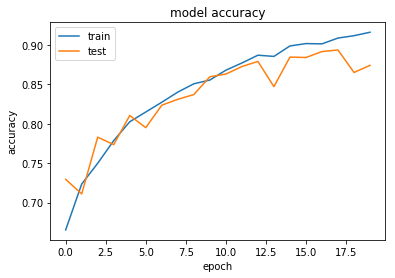

In [7]:
path = 'results'
name = 'adam'

plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

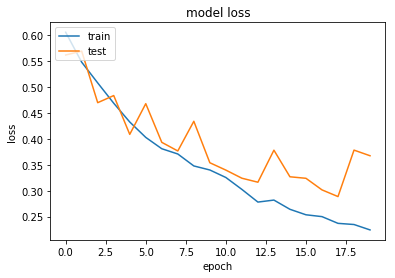

In [8]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [22]:
print(fitted_model.history)
type(fitted_model.history)

{'val_loss': [0.562253131389618, 0.5697533297538757, 0.4701339502334595, 0.4839192991256714, 0.40892509174346925, 0.4682288703918457, 0.39353693795204164, 0.37685635256767275, 0.43419545245170593, 0.35410169792175294, 0.3398827633857727, 0.3242215735912323, 0.31648041474819183, 0.37839411520957944, 0.32698113334178924, 0.324056542634964, 0.3016740772724152, 0.2887337546348572, 0.3785077223777771, 0.36761871093511583], 'val_acc': [0.7295, 0.711, 0.783, 0.7735, 0.8105, 0.795, 0.8235, 0.831, 0.837, 0.8595, 0.863, 0.8725, 0.879, 0.847, 0.8845, 0.884, 0.8915, 0.8935, 0.865, 0.874], 'loss': [0.6062272075414658, 0.548413254737854, 0.5083336506485939, 0.4691107716560364, 0.4328267436027527, 0.4030664411187172, 0.38117076909542086, 0.3710180697441101, 0.34792795160412787, 0.34011193776130677, 0.3256089008748531, 0.3026016760468483, 0.27812014684081077, 0.28197080065310004, 0.2641723582148552, 0.2535650508701801, 0.2500124852061272, 0.23701773490011693, 0.23476578956842423, 0.22433070614933967],

dict

In [29]:
torch.save(fitted_model.history,'../input/results_adam_CNN_nobathnorm.pt')

df = pd.DataFrame(fitted_model.history)
df.columns = ["val_loss","val_acc","loss", "acc"]
df.to_csv("../input/results_adam_CNN_nobathnorm2.csv", index=0)

# with open('../input/results_adam_CNN_nobathnorm.csv', 'wb') as csv_file:
#     writer = csv.writer(csv_file)
#     for key, value in fitted_model.history.items():
#        writer.writerow([key, value])

# csv_columns = ['val_loss','val_acc','loss', 'acc']
# csv_file = "../input/results_adam_CNN_nobathnorm.csv"
# try:
#     with open(csv_file, 'w') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
#         writer.writeheader()
#         for data in fitted_model.history:
#             writer.writerow(data)
# except IOError:
#     print("I/O error") 
    
# np.savetxt('../input/results_adam_CNN_nobathnorm.csv', fitted_model.history, delimiter=',')    